In [1]:
# MTREND

In [1]:
import datetime as dt

import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pandas_market_calendars as mcal
import plotly.graph_objects as go
import polars as pl
from dash import Dash, dcc, html
from plotly.subplots import make_subplots

nse = mcal.get_calendar("NSE")

In [2]:
pd.set_option("display.max_rows", 25_000)
pd.set_option("display.max_columns", 500)
pl.Config.set_tbl_cols(500)
pl.Config.set_tbl_rows(10_000)

pd.options.display.float_format = "{:.4f}".format

In [3]:
import sys

sys.path.append("..")
from tooling.enums import AssetClass, Index, Spot, StrikeSpread
from tooling.fetch import fetch_option_data, fetch_spot_data
from tooling.filter import find_atm, option_tool

In [4]:
def get_expiry(f_today):
    days_to_thursday = (3 - f_today.weekday()) % 7
    nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
    f_expiry = nearest_thursday
    if nse.valid_days(start_date=nearest_thursday, end_date=nearest_thursday).empty:
        f_expiry = nearest_thursday - dt.timedelta(days=1)
    return f_expiry


def get_option_contract_name(symbol, strike, expiry, opt_type):
    temp = "0"
    mth = expiry.month

    if (expiry + dt.timedelta(days=7)).month != expiry.month:
        date_string = expiry.strftime("%y%b").upper()
        return f"{symbol}{date_string}{strike}{opt_type}"
    else:
        if expiry.day <= 9:
            date_string = f"{expiry.year - 2000}{mth}{temp}{expiry.day}"
        else:
            date_string = f"{expiry.year - 2000}{mth}{expiry.day}"
        return f"{symbol}{date_string}{strike}{opt_type}"

In [5]:
bnf_pandas = pd.read_csv("../data/nifty_1hr_tv (9).csv")
# bnf_pandas = pd.read_csv("../data/finnifty_1hr_tv (2).csv")
# bnf_pandas = pd.read_csv('../data/midcp_1hr_tv (4).csv')
# bnf_pandas = pd.read_csv('../data/finnifty_1hr_tv.csv')
# bnf_pandas = pd.read_csv('../data/bnf_fut_1hr_tv.csv')
# bnf_pandas = pd.read_csv('../data/gold_4hr_tv.csv')

In [6]:
# bnf_pandas

In [7]:
# If Stocks Data ...
bnf_pandas["datetime"] = pd.to_datetime(bnf_pandas["time"])
bnf_pandas["datetime"] = bnf_pandas["datetime"].dt.tz_localize(None)
bnf_pandas = bnf_pandas[bnf_pandas["datetime"].dt.year >= 2017]
bnf_pandas.drop(columns=["time"], inplace=True)
# bnf_pandas

In [8]:
bnf = pl.DataFrame(bnf_pandas)
print(type(bnf))
# bnf

<class 'polars.dataframe.frame.DataFrame'>


In [9]:
# # For crude oil Data
# bnf1 = pd.DataFrame(bnf_pandas)
# bnf1 = bnf1.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
# bnf1['datetime'] = pd.to_datetime(bnf1['datetime'])
# bnf1['index'] = bnf1['datetime']
# bnf1.rename(columns={'o': 'open', 'h': 'high', 'l': 'low', 'c': 'close'}, inplace=True)
# bnf = pl.DataFrame(bnf1)
# print(type(bnf))
# bnf

In [10]:
# bnf['datetime'] = pd.to_datetime(bnf['datetime'])
# bnf = bnf.drop(columns=['Unnamed: 0'])
# bnf.set_index(bnf['datetime'], inplace=True)
# bnf
# bnf = bnf.with_columns(pl.col('datetime').str.to_datetime(format='%Y-%m-%dT%H:%M:%S.%f'))
# print(bnf)
# bnf = bnf.with_columns(pl.col('datetime').cast(pl.DateTime))

# Set 'datetime' column as index
bnf = bnf.with_columns([pl.col("datetime").alias("index")]).drop("datetime")

# Now 'datetime' is set as the index
# bnf

In [11]:
bnf = bnf.with_columns(pl.col("index").alias("datetime"))
# bnf

In [12]:
bnf.tail()

shape: (5, 8)
┌─────────┬──────────┬──────────┬──────────┬─────────────┬────────┬────────────────┬───────────────┐
│ open    ┆ high     ┆ low      ┆ close    ┆ MA          ┆ Shapes ┆ index          ┆ datetime      │
│ ---     ┆ ---      ┆ ---      ┆ ---      ┆ ---         ┆ ---    ┆ ---            ┆ ---           │
│ f64     ┆ f64      ┆ f64      ┆ f64      ┆ f64         ┆ i64    ┆ datetime[ns]   ┆ datetime[ns]  │
╞═════════╪══════════╪══════════╪══════════╪═════════════╪════════╪════════════════╪═══════════════╡
│ 25315.8 ┆ 25322.0  ┆ 25281.8  ┆ 25300.5  ┆ 24884.76    ┆ 1      ┆ 2024-09-02     ┆ 2024-09-02    │
│         ┆          ┆          ┆          ┆             ┆        ┆ 11:15:00       ┆ 11:15:00      │
│ 25301.5 ┆ 25304.1  ┆ 25235.5  ┆ 25255.7  ┆ 24896.76875 ┆ 1      ┆ 2024-09-02     ┆ 2024-09-02    │
│         ┆          ┆          ┆          ┆             ┆        ┆ 12:15:00       ┆ 12:15:00      │
│ 25255.8 ┆ 25283.65 ┆ 25244.95 ┆ 25275.75 ┆ 24909.78625 ┆ 1      ┆ 2024-09-02     ┆ 2024-09-02    │
│         ┆          ┆          ┆          ┆             ┆        ┆ 13:15:00       ┆ 13:15:00      │
│ 25275.4 ┆ 25290.35 ┆ 25258.0  ┆ 25280.1  ┆ 24920.54    ┆ 1      ┆ 2024-09-02     ┆ 2024-09-02    │
│         ┆          ┆          ┆          ┆             ┆        ┆ 14:15:00       ┆ 14:15:00      │
│ 25279.6 ┆ 25289.85 ┆ 25258.6  ┆ 25273.9  ┆ 24930.92875 ┆ 1      ┆ 2024-09-02     ┆ 2024-09-02    │
│         ┆          ┆          ┆          ┆             ┆        ┆ 15:15:00       ┆ 15:15:00      │
└─────────┴──────────┴──────────┴──────────┴─────────────┴────────┴────────────────┴───────────────┘

In [13]:
# def resample(
#     data: pl.DataFrame, timeframe, offset: dt.timedelta | None = None
# ) -> pl.DataFrame:
#     return (
#         data.set_sorted("datetime")
#         .group_by_dynamic(
#             index_column="datetime",
#             every=timeframe,
#             period=timeframe,
#             truncate=True,
#             offset=offset,
#         )
#         .agg(
#             [
#                 pl.col("open").first().alias("open"),
#                 pl.col("high").max().alias("high"),
#                 pl.col("low").min().alias("low"),
#                 pl.col("close").last().alias("close"),
#                 pl.col("volume").sum().alias("volume"),
#             ]
#         )
#     )

# ohlc_resampled = resample(bnf, '60m', pd.Timedelta(minutes=15))

# # bnf_df = bnf.to_pandas()
# # bnf_df.set_index(bnf_df['datetime'], inplace=True)
# # ohlc_15min = bnf_df.resample('60min').agg({
# #     'open': 'first',
# #     'high': 'max',
# #     'low': 'min',
# #     'close': 'last',
# # })

# # ohlc_15min.dropna(inplace=True)

# # ohlc_15min.reset_index(inplace=True)

# # bnf_1hr = ohlc_15min
# bnf_1hr = ohlc_resampled
# bnf_final = bnf_1hr.to_pandas()
# bnf_final['datetime'] = pd.to_datetime(bnf_final['datetime'])
# # bnf_final
# # bnf_1hr

In [14]:
# bnf_final = bnf
# bnf_final

In [15]:
# # bnf_final = bnf_1hr
# bnf_final['datetime'] = pd.to_datetime(bnf_final['datetime'])
# bnf_final

In [16]:
def generate_signals1(df, signal_ma, trailing_ma):
    df["close"] = pd.to_numeric(df["close"], errors="coerce")
    df["MA20"] = df["close"].rolling(window=signal_ma).mean()
    df["MA10"] = df["close"].rolling(window=trailing_ma).mean()

    df["Buy_Signal"] = 0

    # Generate signals using boolean masking
    buy_signal_mask = (
        (df["MA20"] > df["MA20"].shift(1))
        # & (df["MA20"].shift(1) > df["MA20"].shift(2))
        # & (df['MA20'].shift(2) > df['MA20'].shift(3))
        # & (df['MA20'].shift(3) > df['MA20'].shift(4))
        # & (df['MA20'].shift(4) > df['MA20'].shift(5))
    )

    df.loc[buy_signal_mask, "Buy_Signal"] = 1

    return df

In [17]:
def generate_signals2(df):
    df["close"] = pd.to_numeric(df["close"], errors="coerce")
    df["MA20"] = df["close"].rolling(window=50).mean()
    df["MA10"] = df["close"].rolling(window=49).mean()

    df["Sell_Signal"] = 0

    # Generate signals using boolean masking
    sell_signal_mask = (
        (df["MA20"] < df["MA20"].shift(1))
        & (df["MA20"].shift(1) < df["MA20"].shift(2))
        & (df["MA20"].shift(2) < df["MA20"].shift(3))
        & (df["MA20"].shift(3) < df["MA20"].shift(4))
        & (df["MA20"].shift(4) < df["MA20"].shift(5))
        # & (df['MA20'].shift(5) < df['MA20'].shift(6))
        # & (df['MA20'].shift(6) < df['MA20'].shift(7))
    )

    df.loc[sell_signal_mask, "Sell_Signal"] = 1

    return df

In [19]:
# Positional

def execute(df):

    trade_book = []
    in_trade = False
    signal_entry_price = 100000
    signal_initial_sl = 0
    already_signal_exists = False
    is_trailing_active = False
    remark = ""
    portfolio_value = 7500000

    for i in range(1, len(df)):
        points = 0
        current_candle_open = df.iloc[i]["o"]
        current_candle_high = df.iloc[i]["h"]
        current_candle_low = df.iloc[i]["l"]
        current_candle_close = df.iloc[i]["c"]
        current_moving_average_price = df.iloc[i]["MA10"]

        if not in_trade:
            if df.iloc[i]["Buy_Signal"] == 1:
                if not already_signal_exists:
                    # Fresh Buy Signal
                    # print(df.iloc[i])
                    # print('Fresh Buy Signal')
                    signal_entry_price = current_candle_high
                    signal_initial_sl = current_candle_low
                    signal_creation_time = df.iloc[i]["datetime"]
                    already_signal_exists = True

                    # if (signal_entry_price - signal_initial_sl > 400):
                    #     # Skip Signal Candle Due To Big Size
                    #     already_signal_exists = False
                    #     signal_entry_price = 100000
                    #     signal_initial_sl = 0

                else:
                    if current_candle_open > signal_entry_price:
                        # Gap Up Open, SKIP trade
                        # print(df.iloc[i])
                        # print('Gap Up Open, Skip Trade')
                        already_signal_exists = False
                        signal_entry_price = 100000
                        signal_initial_sl = 0
                    elif current_candle_high < signal_entry_price:
                        # Better Candle
                        # print(df.iloc[i])
                        # print('Better Candle')
                        signal_entry_price = current_candle_high
                        signal_initial_sl = current_candle_low
                        signal_creation_time = df.iloc[i]["datetime"]

                        # if (signal_entry_price - signal_initial_sl > 400):
                        #     # Skip Signal Candle Due To Big Size
                        #     already_signal_exists = False
                        #     signal_entry_price = 100000
                        #     signal_initial_sl = 0

                    elif current_candle_high > signal_entry_price:
                        # Entry Triggered
                        # print(df.iloc[i])
                        # print('Entry Triggered')
                        in_trade = True
                        entry_time = df.iloc[i]["datetime"]
                        entry_price = signal_entry_price
                        points = 0
            else:
                if df.iloc[i - 1]["Buy_Signal"] == 1:
                    # Considering the forward bias condition as well now
                    signal_entry_price = df.iloc[i - 1]["h"]
                    signal_initial_sl = df.iloc[i - 1]["l"]
                    signal_creation_time = df.iloc[i - 1]["datetime"]
                    already_signal_exists = True

                    if current_candle_high > signal_entry_price:
                        in_trade = True
                        entry_time = df.iloc[i]["datetime"]
                        entry_price = signal_entry_price
                        points = 0
                    else:
                        # Discard Existing Signal
                        already_signal_exists = False
                        signal_entry_price = 100000
                        signal_initial_sl = 0

        if in_trade:
            trade_entry_price = signal_entry_price
            trade_initial_sl = signal_initial_sl
            trade_final_sl = signal_initial_sl

            if (
                not is_trailing_active
                and current_candle_low > current_moving_average_price
            ):
                is_trailing_active = True

            if not is_trailing_active:
                if current_candle_open < trade_initial_sl:
                    # if df.iloc[i-1]['l'] < trade_initial_sl:
                    #     #Previous Candle Already Hit the SL Hence don't check gap down
                    #     print(df.iloc[i])
                    #     print('Initial SL Hit Before Gap Down')
                    #     in_trade = False
                    #     points = trade_initial_sl - trade_entry_price
                    #     exit_price = trade_initial_sl
                    #     exit_time = df.iloc[i-1]['datetime']
                    #     remark = 'Initial SL Hit Before Gap Down'
                    # else:
                    if (
                        df.iloc[i]["datetime"].date() == entry_time.date()
                        and df.iloc[i]["datetime"].time() == entry_time.time()
                    ):
                        if current_candle_close <= trade_initial_sl:
                            in_trade = False
                            points = trade_initial_sl - trade_entry_price
                            exit_price = trade_initial_sl
                            exit_time = df.iloc[i]["datetime"]
                            remark = "Initial SL hit"

                    else:
                        # Gap Open Outside ISL
                        # print(df.iloc[i])
                        # print('Gap Open Outside ISL')
                        in_trade = False
                        points = current_candle_open - trade_entry_price
                        exit_price = current_candle_open
                        exit_time = df.iloc[i]["datetime"]
                        remark = "Gap Open Outside ISL"

                elif current_candle_low <= trade_initial_sl:
                    # Initial SL Hit
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = trade_initial_sl - trade_entry_price
                    exit_price = trade_initial_sl
                    exit_time = df.iloc[i]["datetime"]
                    remark = "Initial SL Hit"

            else:
                trade_final_sl = max(trade_initial_sl, current_moving_average_price)

                if current_candle_open <= trade_initial_sl:
                    # if df.iloc[i-1]['l'] < trade_initial_sl:
                    #     #Previous Candle Already Hit the SL Hence don't check gap down
                    #     print(df.iloc[i])
                    #     print('Initial SL Hit Before Gap Down')
                    #     in_trade = False
                    #     points = trade_initial_sl - trade_entry_price
                    #     exit_price = trade_initial_sl
                    #     exit_time = df.iloc[i-1]['datetime']
                    #     remark = 'Initial SL Hit'
                    # else:
                    if (
                        df.iloc[i]["datetime"].date() == entry_time.date()
                        and df.iloc[i]["datetime"].time() == entry_time.time()
                    ):
                        if current_candle_close <= trade_initial_sl:
                            in_trade = False
                            points = trade_initial_sl - trade_entry_price
                            exit_price = trade_initial_sl
                            exit_time = df.iloc[i]["datetime"]
                            remark = "Initial SL hit"

                    else:
                        # Gap Open Outside ISL
                        # print(df.iloc[i])
                        # print('Gap Open Outside ISL')
                        in_trade = False
                        points = current_candle_open - trade_entry_price
                        exit_price = current_candle_open
                        exit_time = df.iloc[i]["datetime"]
                        remark = "Gap Open Outside ISL"

                elif current_candle_low <= trade_initial_sl:
                    # if trade_initial_sl >= current_moving_average_price:
                    # Despite Trailing, Initial SL hit
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = trade_initial_sl - trade_entry_price
                    exit_price = trade_initial_sl
                    exit_time = df.iloc[i]["datetime"]
                    remark = "Initial SL hit"

                elif current_candle_close <= trade_final_sl:
                    # Price Closed below TSL i.e. MA10 , TSL Hit
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = current_candle_close - trade_entry_price
                    exit_price = current_candle_close
                    exit_time = df.iloc[i]["datetime"]
                    is_trailing_active = False
                    remark = "TSL Hit"

            if points:
                index_lev = 5.8333
                qty = int(round(portfolio_value * index_lev / entry_price / 25)) * 25
                slippage = 0.0002 * (entry_price + exit_price)
                # slippage = 10
                final_points = points - slippage
                # final_points = points
                trade = {
                    "Signal Generated At": signal_creation_time,
                    "Trade Type": "LONG",
                    "Entry Time": entry_time,
                    "Entry Price": entry_price,
                    "Initial SL": trade_initial_sl,
                    "Final SL": trade_final_sl,
                    "Exit Time": exit_time,
                    "Exit Price": exit_price,
                    "Points Captured": points,
                    "After Costs": final_points,
                    "PnL": final_points * qty,
                    "Remarks": remark,
                    "Qty": qty,
                    "Leverage": index_lev,
                    "ROI%": (final_points * qty / portfolio_value) * 100,
                    "Trade Year": entry_time.year,
                    "Trade Month": entry_time.month,
                }
                trade_book.append(trade)
                points = 0
                in_trade = False
                already_signal_exists = False
                remark = ""
                is_trailing_active = False

    trade_book_df = pd.DataFrame(trade_book)
    return trade_book_df

In [20]:
bnf1 = bnf
bnf2 = bnf

In [21]:
def generate_stats(tb_expiry, signal_ma, trailing_ma):
    stats_df8 = pd.DataFrame(
        index=range(2017, 2025),
        columns=[
            "Total ROI",
            "Total Trades",
            "Win Rate",
            "Avg Profit% per Trade",
            "Avg Loss% per Trade",
            "Max Drawdown",
            "ROI/DD Ratio",
            "Variation",
        ],
    )
    combined_df_sorted = tb_expiry
    # combined_df_sorted = tb_expiry_ce
    # combined_df_sorted = tb_expiry_pe
    
    # Iterate over each year
    for year in range(2017, 2025):
        # Filter trades for the current year
        year_trades = combined_df_sorted[(combined_df_sorted["Trade Year"] == year)]
    
        # Calculate total ROI
        total_roi = year_trades["ROI%"].sum()
    
        # Calculate total number of trades
        total_trades = len(year_trades)
    
        # Calculate win rate
        win_rate = (year_trades["ROI%"] > 0).mean() * 100
    
        # Calculate average profit per trade
        avg_profit = year_trades[year_trades["ROI%"] > 0]["ROI%"].mean()
    
        # Calculate average loss per trade
        avg_loss = year_trades[year_trades["ROI%"] < 0]["ROI%"].mean()
    
        # Calculate maximum drawdown
        max_drawdown = (
            year_trades["ROI%"].cumsum() - year_trades["ROI%"].cumsum().cummax()
        ).min()
    
        # Calculate ROI/DD ratio
        roi_dd_ratio = total_roi / abs(max_drawdown)

        variation = f'{signal_ma} , {trailing_ma}'
    
        # Store the statistics in the DataFrame
        stats_df8.loc[year] = [
            total_roi,
            total_trades,
            win_rate,
            avg_profit,
            avg_loss,
            max_drawdown,
            roi_dd_ratio,
            variation,
        ]
    
    # Calculate overall statistics
    overall_total_roi = stats_df8["Total ROI"].sum()
    overall_total_trades = stats_df8["Total Trades"].sum()
    overall_win_rate = (combined_df_sorted["ROI%"] > 0).mean() * 100
    overall_avg_profit = combined_df_sorted[combined_df_sorted["ROI%"] > 0]["ROI%"].mean()
    overall_avg_loss = combined_df_sorted[combined_df_sorted["ROI%"] < 0]["ROI%"].mean()
    overall_max_drawdown = (
        combined_df_sorted["ROI%"].cumsum() - combined_df_sorted["ROI%"].cumsum().cummax()
    ).min()
    overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)
    overall_variation = variation
    
    # Store the overall statistics in the DataFrame
    stats_df8.loc["Overall"] = [
        overall_total_roi,
        overall_total_trades,
        overall_win_rate,
        overall_avg_profit,
        overall_avg_loss,
        overall_max_drawdown,
        overall_roi_dd_ratio,
        overall_variation,
    ]
    return {overall_roi_dd_ratio : stats_df8}

In [22]:
bnf1 = bnf1.to_pandas()
bnf2 = bnf2.to_pandas()
# signals_df1 = generate_signals1(bnf1)
# signals_df2 = generate_signals2(bnf2)

In [ ]:
stats_dictionary = {}

for i in range(6, 81):
    for j in range(4, 101, 2):
        print(f"Signal MA : {i} , Trailing MA : {j}")
        signals_df1 = generate_signals1(bnf1, i, j)
        signals_df1 = signals_df1.rename(columns={"open": "o", "high": "h", "low": "l", "close": "c"})
        new_tb = execute(signals_df1)
        new_tb["DD%"] = new_tb["ROI%"].cumsum() - new_tb["ROI%"].cumsum().cummax()
        tradebook_buy_side = new_tb
        stats = generate_stats(tradebook_buy_side, i, j)
        for overall_roi_dd_ratio, stats_df in stats.items():
            if overall_roi_dd_ratio is not None and overall_roi_dd_ratio > 10:
                print(stats_df.to_string())
                stats_dictionary[overall_roi_dd_ratio] = stats_df

Signal MA : 6 , Trailing MA : 4
Signal MA : 6 , Trailing MA : 6
Signal MA : 6 , Trailing MA : 8
Signal MA : 6 , Trailing MA : 10
Signal MA : 6 , Trailing MA : 12
Signal MA : 6 , Trailing MA : 14
Signal MA : 6 , Trailing MA : 16
Signal MA : 6 , Trailing MA : 18
Signal MA : 6 , Trailing MA : 20
Signal MA : 6 , Trailing MA : 22
Signal MA : 6 , Trailing MA : 24
Signal MA : 6 , Trailing MA : 26
Signal MA : 6 , Trailing MA : 28
Signal MA : 6 , Trailing MA : 30
Signal MA : 6 , Trailing MA : 32
Signal MA : 6 , Trailing MA : 34
Signal MA : 6 , Trailing MA : 36
Signal MA : 6 , Trailing MA : 38
Signal MA : 6 , Trailing MA : 40
Signal MA : 6 , Trailing MA : 42
Signal MA : 6 , Trailing MA : 44
Signal MA : 6 , Trailing MA : 46
Signal MA : 6 , Trailing MA : 48
Signal MA : 6 , Trailing MA : 50
Signal MA : 6 , Trailing MA : 52
Signal MA : 6 , Trailing MA : 54
Signal MA : 6 , Trailing MA : 56
Signal MA : 6 , Trailing MA : 58
Signal MA : 6 , Trailing MA : 60
Signal MA : 6 , Trailing MA : 62
Signal MA : 6

In [23]:
sorted_stats = {k: v for k, v in sorted(stats_dictionary.items(), key=lambda item: item[0], reverse=True)}
sorted_stats

{22.545665362358747:         Total ROI Total Trades Win Rate Avg Profit% per Trade  \
 2017     122.5615           51  21.5686               17.5657   
 2018      77.0829           49  22.4490               14.7792   
 2019     140.3907           41  21.9512               21.8658   
 2020     232.7133           41  31.7073               24.5641   
 2021      34.3466           41  21.9512               12.2512   
 2022     115.7437           41  19.5122               25.2308   
 2023      59.1336           56  23.2143               10.1328   
 2024      22.1352           28  21.4286               14.1241   
 Overall  804.1076          348  22.9885               17.5062   
 
         Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation  
 2017                -1.7665     -15.7464       7.7835   80 , 88  
 2018                -2.2497     -35.6657       2.1613   80 , 88  
 2019                -1.7625     -26.2742       5.3433   80 , 88  
 2020                -3.0936     -32.3680       7.

In [345]:
signals_df1 = signals_df1.rename(
    columns={"open": "o", "high": "h", "low": "l", "close": "c"}
)
signals_df2 = signals_df2.rename(
    columns={"open": "o", "high": "h", "low": "l", "close": "c"}
)

In [276]:
# signals_df2.tail(130)

In [266]:

new_tb = execute(signals_df1)
new_tb["DD%"] = new_tb["ROI%"].cumsum() - new_tb["ROI%"].cumsum().cummax()
tradebook_buy_side = new_tb
# new_tb

In [267]:
# tradebook_buy_side['DD%'] = (tradebook_buy_side['ROI%'].cumsum() - tradebook_buy_side['ROI%'].cumsum().cummax())
# tradebook_buy_side

In [269]:
new_tb

Signal Generated At Trade Type          Entry Time  Entry Price  \
0   2017-01-11 10:15:00       LONG 2017-01-11 11:15:00   18688.0000   
1   2017-01-19 10:15:00       LONG 2017-01-19 11:15:00   19126.5000   
2   2017-01-20 10:15:00       LONG 2017-01-20 11:15:00   19038.1000   
3   2017-01-20 15:15:00       LONG 2017-01-23 09:15:00   18867.0000   
4   2017-01-24 11:15:00       LONG 2017-01-24 12:15:00   18994.8000   
5   2017-01-24 13:15:00       LONG 2017-01-24 14:15:00   19048.0000   
6   2017-01-31 11:15:00       LONG 2017-01-31 12:15:00   19559.2000   
7   2017-01-31 15:15:00       LONG 2017-02-01 09:15:00   19603.9500   
8   2017-02-01 12:15:00       LONG 2017-02-01 13:15:00   20019.0000   
9   2017-02-08 12:15:00       LONG 2017-02-08 13:15:00   20366.8500   
10  2017-02-08 14:15:00       LONG 2017-02-08 15:15:00   20378.9500   
11  2017-02-09 11:15:00       LONG 2017-02-09 12:15:00   20169.0500   
12  2017-02-17 10:15:00       LONG 2017-02-17 11:15:00   20622.9000   
13  2017-02-17 15:15:00       LONG 2017-02-20 09:15:00   20540.5000   
14  2017-02-27 10:15:00       LONG 2017-02-27 11:15:00   20777.9000   
15  2017-02-27 15:15:00       LONG 2017-02-28 09:15:00   20698.3500   
16  2017-02-28 13:15:00       LONG 2017-02-28 14:15:00   20689.1000   
17  2017-03-08 14:15:00       LONG 2017-03-08 15:15:00   20754.3000   
18  2017-03-09 10:15:00       LONG 2017-03-09 11:15:00   20766.3000   
19  2017-03-09 13:15:00       LONG 2017-03-09 14:15:00   20772.7000   
20  2017-03-14 10:15:00       LONG 2017-03-14 11:15:00   21207.0000   
21  2017-03-14 15:15:00       LONG 2017-03-15 09:15:00   21158.0000   
22  2017-03-15 12:15:00       LONG 2017-03-15 13:15:00   21256.1500   
23  2017-03-16 11:15:00       LONG 2017-03-16 12:15:00   21286.9500   
24  2017-03-17 11:15:00       LONG 2017-03-17 12:15:00   21232.6000   
25  2017-03-20 10:15:00       LONG 2017-03-20 11:15:00   21185.0000   
26  2017-03-21 12:15:00       LONG 2017-03-21 13:15:00   21095.0000   
27  2017-03-22 11:15:00       LONG 2017-03-22 12:15:00   20936.1000   
28  2017-03-28 10:15:00       LONG 2017-03-28 11:15:00   21228.5000   
29  2017-04-03 10:15:00       LONG 2017-04-03 11:15:00   21504.8000   
30  2017-04-06 13:15:00       LONG 2017-04-06 14:15:00   21608.0000   
31  2017-04-07 12:15:00       LONG 2017-04-07 13:15:00   21585.0000   
32  2017-04-07 15:15:00       LONG 2017-04-10 09:15:00   21450.0000   
33  2017-04-18 10:15:00       LONG 2017-04-18 11:15:00   21967.9000   
34  2017-04-18 15:15:00       LONG 2017-04-19 09:15:00   21710.0000   
35  2017-04-19 11:15:00       LONG 2017-04-19 12:15:00   21629.9000   
36  2017-04-20 10:15:00       LONG 2017-04-20 11:15:00   21580.0000   
37  2017-04-24 12:15:00       LONG 2017-04-24 13:15:00   21799.0000   
38  2017-05-03 12:15:00       LONG 2017-05-03 13:15:00   22347.6000   
39  2017-05-09 10:15:00       LONG 2017-05-09 11:15:00   22754.0000   
40  2017-05-12 10:15:00       LONG 2017-05-12 11:15:00   22785.3500   
41  2017-05-12 14:15:00       LONG 2017-05-12 15:15:00   22682.1000   
42  2017-05-16 10:15:00       LONG 2017-05-16 11:15:00   22819.5000   
43  2017-05-18 10:15:00       LONG 2017-05-18 11:15:00   22773.7500   
44  2017-05-23 12:15:00       LONG 2017-05-23 13:15:00   22697.9500   
45  2017-05-25 13:15:00       LONG 2017-05-25 14:15:00   23077.9500   
46  2017-05-30 12:15:00       LONG 2017-05-30 13:15:00   23220.0000   
47  2017-06-02 10:15:00       LONG 2017-06-02 11:15:00   23352.5000   
48  2017-06-05 10:15:00       LONG 2017-06-05 11:15:00   23389.5500   
49  2017-06-09 10:15:00       LONG 2017-06-09 11:15:00   23534.9000   
50  2017-06-12 15:15:00       LONG 2017-06-13 09:15:00   23465.0000   
51  2017-06-14 10:15:00       LONG 2017-06-14 11:15:00   23411.7500   
52  2017-06-14 12:15:00       LONG 2017-06-14 13:15:00   23499.0000   
53  2017-06-19 13:15:00       LONG 2017-06-19 14:15:00   23687.0000   
54  2017-06-21 13:15:00       LONG 2017-06-21 14:15:00   23698.1000   
55  2017-06-23 11:15:00     

In [270]:
stats_df5 = pd.DataFrame(
    index=range(2017, 2025),
    columns=[
        "Total ROI",
        "Total Trades",
        "Win Rate",
        "Avg Profit% per Trade",
        "Avg Loss% per Trade",
        "Max Drawdown",
        "ROI/DD Ratio",
    ],
)

# Iterate over each year
for year in range(2017, 2025):
    # Filter trades for the current year
    year_trades = new_tb[(new_tb["Trade Year"] == year)]

    # Calculate total ROI
    total_roi = year_trades["ROI%"].sum()

    # Calculate total number of trades
    total_trades = len(year_trades)

    # Calculate win rate
    win_rate = (year_trades["ROI%"] > 0).mean() * 100

    # Calculate average profit per trade
    avg_profit = year_trades[year_trades["ROI%"] > 0]["ROI%"].mean()

    # Calculate average loss per trade
    avg_loss = year_trades[year_trades["ROI%"] < 0]["ROI%"].mean()

    # Calculate maximum drawdown
    max_drawdown = (
        year_trades["ROI%"].cumsum() - year_trades["ROI%"].cumsum().cummax()
    ).min()

    # Calculate ROI/DD ratio
    roi_dd_ratio = total_roi / abs(max_drawdown)

    # Store the statistics in the DataFrame
    stats_df5.loc[year] = [
        total_roi,
        total_trades,
        win_rate,
        avg_profit,
        avg_loss,
        max_drawdown,
        roi_dd_ratio,
    ]

# Calculate overall statistics
overall_total_roi = stats_df5["Total ROI"].sum()
overall_total_trades = stats_df5["Total Trades"].sum()
overall_win_rate = (new_tb["ROI%"] > 0).mean() * 100
overall_avg_profit = new_tb[new_tb["ROI%"] > 0]["ROI%"].mean()
overall_avg_loss = new_tb[new_tb["ROI%"] < 0]["ROI%"].mean()
overall_max_drawdown = (
    new_tb["ROI%"].cumsum() - new_tb["ROI%"].cumsum().cummax()
).min()
overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)

# Store the overall statistics in the DataFrame
stats_df5.loc["Overall"] = [
    overall_total_roi,
    overall_total_trades,
    overall_win_rate,
    overall_avg_profit,
    overall_avg_loss,
    overall_max_drawdown,
    overall_roi_dd_ratio,
]
stats_df5

Total ROI Total Trades Win Rate Avg Profit% per Trade  \
2017      67.4012          100  27.0000                7.3231   
2018      12.9081           95  26.3158                6.5213   
2019     126.4495           75  32.0000               10.8059   
2020     234.7728           75  33.3333               17.5743   
2021     171.1332           80  33.7500               12.2882   
2022      59.7517           90  23.3333               11.7477   
2023      78.2004           80  32.5000                6.3777   
2024     -14.1747           60  28.3333                5.6837   
Overall  736.4424     655.0000  29.3130                9.8978   

        Avg Loss% per Trade Max Drawdown ROI/DD Ratio  
2017                -1.7852     -25.1739       2.6774  
2018                -2.1446     -42.4918       0.3038  
2019                -2.6057     -27.8201       4.5453  
2020                -4.0917     -37.9131       6.1924  
2021                -3.0311     -39.0647       4.3808  
2022                -2.7094     -62.6369       0.9539  
2023                -1.6226     -26.6667       2.9325  
2024                -2.5767     -35.2914      -0.4016  
Overall             -2.5139     -62.6369      11.7573

In [51]:
# tradebook_buy_side['After Costs'].sum()
# tradebook_buy_side.loc[tradebook_buy_side["Trade Year"] < 2024, "ROI%"].sum()

In [52]:
# tradebook_buy_side.to_csv("FNF_Long_Only_MTrend_5X_Lev_80_1_80.csv")
# tradebook_buy_side.to_csv("MIDCP_Long_Only_MTrend_5xLev_9_1_68.csv")

In [53]:
# 9 (Signal MA) , 68 (Trailing MA) , 1 (No. of Candles) : MIDCP -> Buy Best Variation
# 0.05% of Entry + Exit -> Slippage , 5x leverage

In [172]:
# Positional Sell Side


def execute_sell_side(df):
    portfolio_value = 7500000
    trade_book = []
    in_trade = False
    signal_entry_price = 100000
    signal_initial_sl = 0
    already_signal_exists = False
    remark = ""
    is_trailing_active = False

    for i in range(1, len(df)):
        points = 0
        current_candle_open = df.iloc[i]["o"]
        current_candle_high = df.iloc[i]["h"]
        current_candle_low = df.iloc[i]["l"]
        current_candle_close = df.iloc[i]["c"]
        current_moving_average_price = df.iloc[i]["MA10"]

        if not in_trade:
            if df.iloc[i]["Sell_Signal"] == 1:
                if not already_signal_exists:
                    # Fresh Sell Signal
                    print(df.iloc[i])
                    print('Fresh Short Sell Signal')
                    signal_entry_price = current_candle_low
                    signal_initial_sl = current_candle_high
                    signal_creation_time = df.iloc[i]["datetime"]
                    already_signal_exists = True

                    # if (signal_initial_sl - signal_entry_price > 400):
                    #     # Skip Signal Candle Due To Big Size
                    #     already_signal_exists = False
                    #     signal_entry_price = 100000
                    #     signal_initial_sl = 0

                else:
                    if current_candle_open < signal_entry_price:
                        # Gap Down Outside, SKIP trade
                        print('Signal Entry Price' , signal_entry_price)
                        print(df.iloc[i])
                        print('Gap Outside, Skip Trade')
                        already_signal_exists = False
                        signal_entry_price = 100000
                        signal_initial_sl = 0
                    elif current_candle_low > signal_entry_price:
                        # Better Candle
                        
                        print(df.iloc[i])
                        print('Better Candle')
                        signal_entry_price = current_candle_low
                        signal_initial_sl = current_candle_high
                        signal_creation_time = df.iloc[i]["datetime"]

                        # if (signal_initial_sl - signal_entry_price > 400):
                        #     # Skip Signal Candle Due To Big Size
                        #     already_signal_exists = False
                        #     signal_entry_price = 100000
                        #     signal_initial_sl = 0

                    elif current_candle_low < signal_entry_price:
                        # Entry Triggered
                        
                        print(df.iloc[i])
                        print('Entry Triggered')
                        in_trade = True
                        entry_time = df.iloc[i]["datetime"]
                        entry_price = signal_entry_price
                        points = 0
            else:
                if df.iloc[i - 1]["Sell_Signal"] == 1:
                    # Considering the forward bias condition as well now
                    signal_entry_price = df.iloc[i - 1]["l"]
                    signal_initial_sl = df.iloc[i - 1]["h"]
                    signal_creation_time = df.iloc[i - 1]["datetime"]
                    already_signal_exists = True

                    if current_candle_low < signal_entry_price:
                        in_trade = True
                        entry_time = df.iloc[i]["datetime"]
                        entry_price = signal_entry_price
                        points = 0
                    else:
                        # Discard Existing Signal
                        already_signal_exists = False
                        signal_entry_price = 100000
                        signal_initial_sl = 0

        if in_trade:
            trade_entry_price = signal_entry_price
            trade_initial_sl = signal_initial_sl
            trade_final_sl = signal_initial_sl

            if (
                not is_trailing_active
                and current_candle_high < current_moving_average_price
            ):
                is_trailing_active = True

            if not is_trailing_active:
                if current_candle_open > trade_initial_sl:
                    # if df.iloc[i-1]['h'] > trade_initial_sl:
                    #     #Previous Candle Already Hit the SL Hence don't check gap down
                    #     in_trade = False
                    #     points = -1 * (trade_initial_sl - trade_entry_price)
                    #     exit_price = trade_initial_sl
                    #     exit_time = df.iloc[i-1]['datetime']
                    #     remark = 'Initial SL Hit'
                    # else:
                    if (
                        df.iloc[i]["datetime"].date() == entry_time.date()
                        and df.iloc[i]["datetime"].time() == entry_time.time()
                    ):
                        # continue
                        if current_candle_close >= trade_initial_sl:
                            in_trade = False
                            points = -1 * (trade_initial_sl - trade_entry_price)
                            exit_price = trade_initial_sl
                            exit_time = df.iloc[i]["datetime"]
                            remark = "Initial SL Hit"
                    else:
                        # Gap Open Outside ISL
                        
                        print(df.iloc[i])
                        print('Gap Outside Initial SL')
                        in_trade = False
                        points = trade_entry_price - current_candle_open
                        exit_price = current_candle_open
                        exit_time = df.iloc[i]["datetime"]
                        remark = "Gap Open Outside ISL"

                elif current_candle_high >= trade_initial_sl:
                    # Initial SL Hit
                    
                    print(df.iloc[i])
                    print('Initial SL Hit')
                    in_trade = False
                    points = -1 * (trade_initial_sl - trade_entry_price)
                    exit_price = trade_initial_sl
                    exit_time = df.iloc[i]["datetime"]
                    remark = "Initial SL Hit"

                elif current_candle_close >= trade_final_sl:
                    # TSL Hit
                    print(df.iloc[i])
                    print('TSL Hit')
                    in_trade = False
                    points = -1 * (current_candle_close - trade_entry_price)
                    exit_price = current_candle_close
                    exit_time = df.iloc[i]["datetime"]
                    remark = "TSL Hit"

            elif is_trailing_active:
                trade_final_sl = min(trade_initial_sl, current_moving_average_price)

                if current_candle_open > trade_initial_sl:
                    # if df.iloc[i-1]['h'] > trade_initial_sl:
                    #     #Previous Candle Already Hit the SL Hence don't check gap down
                    #     in_trade = False
                    #     points = -1 * (trade_initial_sl - trade_entry_price)
                    #     exit_price = trade_initial_sl
                    #     exit_time = df.iloc[i-1]['datetime']
                    #     remark = 'Initial SL Hit'
                    # else:
                    if (
                        df.iloc[i]["datetime"].date() == entry_time.date()
                        and df.iloc[i]["datetime"].time() == entry_time.time()
                    ):
                        # continue
                        if current_candle_close >= trade_initial_sl:
                            in_trade = False
                            points = -1 * (trade_initial_sl - trade_entry_price)
                            exit_price = trade_initial_sl
                            exit_time = df.iloc[i]["datetime"]
                            remark = "Initial SL Hit"
                    else:
                        # Gap Open Outside ISL
                        
                        print(df.iloc[i])
                        print('Gap Outside Initial SL')
                        in_trade = False
                        points = trade_entry_price - current_candle_open
                        exit_price = current_candle_open
                        exit_time = df.iloc[i]["datetime"]
                        remark = "Gap Open Outside ISL"

                elif current_candle_high >= trade_initial_sl:
                    # if trade_initial_sl <= current_moving_average_price:
                    # Despite Trailing, Initial SL hit
                    print(df.iloc[i])
                    print('Initial SL Hit')
                    in_trade = False
                    points = -1 * (trade_initial_sl - trade_entry_price)
                    exit_price = trade_initial_sl
                    exit_time = df.iloc[i]["datetime"]
                    remark = "Initial SL hit"

                elif current_candle_close >= trade_final_sl:
                    # Price Closed below TSL i.e. MA10 , TSL Hit
                    print(df.iloc[i])
                    print('TSL Hit')
                    in_trade = False
                    points = -1 * (current_candle_close - trade_entry_price)
                    exit_price = current_candle_close
                    exit_time = df.iloc[i]["datetime"]
                    is_trailing_active = False
                    remark = "TSL Hit"

            if points:
                qty = int(round(portfolio_value * 3.5 / entry_price / 50)) * 50
                slippage = 0.0005 * (entry_price + exit_price)
                # slippage = 10
                final_points = points - slippage
                # final_points = points

                trade = {
                    "Signal Generated At": signal_creation_time,
                    "Trade Type": "SHORT",
                    "Entry Time": entry_time,
                    "Entry Price": entry_price,
                    "Initial SL": trade_initial_sl,
                    "Final SL": trade_final_sl,
                    "Exit Time": exit_time,
                    "Exit Price": exit_price,
                    "Points Captured": points,
                    "After Costs": final_points,
                    "PnL": final_points * qty,
                    "Remarks": remark,
                    "Qty": qty,
                    "Leverage": "3x",
                    "ROI%": (final_points * qty / portfolio_value) * 100,
                    "Trade Year": entry_time.year,
                    "Trade Month": entry_time.month,
                }
                print(trade)
                trade_book.append(trade)
                points = 0
                in_trade = False
                already_signal_exists = False
                remark = ""
                is_trailing_active = False

    trade_book_df = pd.DataFrame(trade_book)
    return trade_book_df

In [173]:
tradebook_sell_side = execute_sell_side(signals_df2)
tradebook_sell_side["DD%"] = (
    tradebook_sell_side["ROI%"].cumsum() - tradebook_sell_side["ROI%"].cumsum().cummax()
)
# tradebook_sell_side

o                        7103.2500
h                        7132.3000
l                        7100.9000
c                        7106.1000
MA                       7154.5081
Shapes                           0
index          2023-01-11 14:15:00
datetime       2023-01-11 14:15:00
MA20                     7148.5220
MA10                     7147.2092
Sell_Signal                      1
Name: 54, dtype: object
Fresh Short Sell Signal
o                        7105.7000
h                        7108.9500
l                        7101.3500
c                        7105.8000
MA                       7154.4513
Shapes                           0
index          2023-01-11 15:15:00
datetime       2023-01-11 15:15:00
MA20                     7146.3810
MA10                     7145.0592
Sell_Signal                      1
Name: 55, dtype: object
Better Candle
o                        7136.4000
h                        7136.5000
l                        7097.4000
c                        7105.0000
MA  

In [174]:
tradebook_sell_side

Signal Generated At Trade Type          Entry Time  Entry Price  \
0  2023-01-11 15:15:00      SHORT 2023-01-12 09:15:00    7101.3500   
1  2023-01-23 13:15:00      SHORT 2023-01-23 14:15:00    7039.0000   
2  2023-01-24 09:15:00      SHORT 2023-01-24 10:15:00    7040.0000   
3  2023-02-02 11:15:00      SHORT 2023-02-02 12:15:00    6916.4000   
4  2023-02-02 15:15:00      SHORT 2023-02-03 09:15:00    6935.0500   
5  2023-02-03 15:15:00      SHORT 2023-02-06 09:15:00    6946.3500   
6  2023-02-20 12:15:00      SHORT 2023-02-20 13:15:00    7016.1000   
7  2023-02-20 14:15:00      SHORT 2023-02-20 15:15:00    6998.9500   
8  2023-02-21 11:15:00      SHORT 2023-02-21 12:15:00    7002.6500   
9  2023-03-01 15:15:00      SHORT 2023-03-02 09:15:00    6870.0500   
10 2023-03-02 11:15:00      SHORT 2023-03-02 12:15:00    6878.0500   
11 2023-03-13 15:15:00      SHORT 2023-03-14 09:15:00    6764.9500   
12 2023-03-15 11:15:00      SHORT 2023-03-15 12:15:00    6770.1500   
13 2023-03-17 09:15:00      SHORT 2023-03-17 10:15:00    6816.6500   
14 2023-03-22 12:15:00      SHORT 2023-03-22 13:15:00    6812.0000   
15 2023-09-21 15:15:00      SHORT 2023-09-22 09:15:00    9067.1500   
16 2023-09-22 09:15:00      SHORT 2023-09-22 10:15:00    9030.2000   
17 2023-09-29 13:15:00      SHORT 2023-09-29 14:15:00    9112.7500   
18 2023-10-09 11:15:00      SHORT 2023-10-09 12:15:00    9019.2500   
19 2023-10-09 14:15:00      SHORT 2023-10-09 15:15:00    9019.6500   
20 2023-10-19 14:15:00      SHORT 2023-10-19 15:15:00    9058.8000   
21 2023-11-02 10:15:00      SHORT 2023-11-02 11:15:00    8814.0000   
22 2024-01-18 13:15:00      SHORT 2024-01-18 14:15:00   10403.4500   
23 2024-01-23 15:15:00      SHORT 2024-01-24 09:15:00   10333.6000   
24 2024-01-24 10:15:00      SHORT 2024-01-24 11:15:00   10444.4000   
25 2024-01-24 15:15:00      SHORT 2024-01-25 09:15:00   10564.2500   
26 2024-02-14 10:15:00      SHORT 2024-02-14 11:15:00   10591.7500   
27 2024-02-28 14:15:00      SHORT 2024-02-28 15:15:00   10762.7500   
28 2024-03-05 10:15:00      SHORT 2024-03-05 11:15:00   10931.9000   
29 2024-03-07 11:15:00      SHORT 2024-03-07 12:15:00   10908.1000   
30 2024-03-07 13:15:00      SHORT 2024-03-07 14:15:00   10891.1500   
31 2024-03-12 15:15:00      SHORT 2024-03-13 09:15:00   10699.3500   
32 2024-03-22 11:15:00      SHORT 2024-03-22 12:15:00   10398.6000   
33 2024-03-22 13:15:00      SHORT 2024-03-22 14:15:00   10398.4000   
34 2024-04-19 13:15:00      SHORT 2024-04-19 14:15:00   10648.0500   
35 2024-04-22 13:15:00      SHORT 2024-04-22 14:15:00   10696.6500   
36 2024-04-23 12:15:00      SHORT 2024-04-23 13:15:00   10763.8500   
37 2024-04-23 14:15:00      SHORT 2024-04-23 15:15:00   10775.5500   
38 2024-04-24 10:15:00      SHORT 2024-04-24 11:15:00   10812.0000   
39 2024-04-24 13:15:00      SHORT 2024-04-24 14:15:00   10823.1500   
40 2024-05-08 15:15:00      SHORT 2024-05-09 09:15:00   10921.8000   
41 2024-05-09 11:15:00      SHORT 2024-05-09 12:15:00   10879.4000   
42 2024-05-13 15:15:00      SHORT 2024-05-14 09:15:00   11081.5500   
43 2024-06-04 15:15:00      SHORT 2024-06-05 09:15:00   10832.1500   
44 2024-07-19 13:15:00      SHORT 2024-07-19 14:15:00   12224.8000   
45 2024-07-25 13:15:00      SHORT 2024-07-25 14:15:00   12375.3000   
46 2024-07-25 15:15:00      SHORT 2024-07-26 09:15:00   12413.3000   
47 2024-08-06 14:15:00      SHORT 2024-08-06 15:15:00   12229.4000   
48 2024-08-07 12:15:00      SHORT 2024-08-07 13:15:00   12499.4500   
49 2024-08-07 15:15:00      SHORT 2024-08-08 09:15:00   12559.4000   
50 2024-08-08 13:15:00      SHORT 2024-08-08 14:15:00   12563.4500   
51 2024-08-09 11:15:00      SHORT 2024-08-09 12:15:00   12617.7000   
52 2024-08-12 14:15:00      SHORT 2024-08-12 15:15:00   12635.8500   
53 2024-08-13 11:15:00      SHORT 2024-08-13 12:15:00   12637.2500   

    Initial SL   Final SL           Exit Time  Exit Price  Points Captured  \
0    7108.9500  7026.8153 2023-01-23 10:15:00   7030.3500          71.0000

In [175]:
stats_df8 = pd.DataFrame(
    index=range(2017, 2025),
    columns=[
        "Total ROI",
        "Total Trades",
        "Win Rate",
        "Avg Profit% per Trade",
        "Avg Loss% per Trade",
        "Max Drawdown",
        "ROI/DD Ratio",
    ],
)
year_trades = tradebook_sell_side
# Iterate over each year
for year in range(2017, 2025):
    # Filter trades for the current year
    year_trades = tradebook_sell_side[(tradebook_sell_side["Trade Year"] == year)]
    # Calculate total ROI
    total_roi = year_trades["ROI%"].sum()
    # Calculate total number of trades
    total_trades = len(year_trades)
    # Calculate win rate
    win_rate = (year_trades["ROI%"] > 0).mean() * 100
    # Calculate average profit per trade
    avg_profit = year_trades[year_trades["ROI%"] > 0]["ROI%"].mean()
    # Calculate average loss per trade
    avg_loss = year_trades[year_trades["ROI%"] < 0]["ROI%"].mean()
    # Calculate maximum drawdown
    max_drawdown = (
        year_trades["ROI%"].cumsum() - year_trades["ROI%"].cumsum().cummax()
    ).min()
    # Calculate ROI/DD ratio
    roi_dd_ratio = total_roi / abs(max_drawdown)
    # Store the statistics in the DataFrame
    stats_df8.loc[year] = [
        total_roi,
        total_trades,
        win_rate,
        avg_profit,
        avg_loss,
        max_drawdown,
        roi_dd_ratio,
    ]
# Calculate overall statistics
overall_total_roi = stats_df8["Total ROI"].sum()
overall_total_trades = stats_df8["Total Trades"].sum()
overall_win_rate = (tradebook_sell_side["ROI%"] > 0).mean() * 100
overall_avg_profit = tradebook_sell_side[tradebook_sell_side["ROI%"] > 0]["ROI%"].mean()
overall_avg_loss = tradebook_sell_side[tradebook_sell_side["ROI%"] < 0]["ROI%"].mean()
overall_max_drawdown = (
    tradebook_sell_side["ROI%"].cumsum() - tradebook_sell_side["ROI%"].cumsum().cummax()
).min()
overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)

# Store the overall statistics in the DataFrame
stats_df8.loc["Overall"] = [
    overall_total_roi,
    overall_total_trades,
    overall_win_rate,
    overall_avg_profit,
    overall_avg_loss,
    overall_max_drawdown,
    overall_roi_dd_ratio,
]
stats_df8

Total ROI Total Trades Win Rate Avg Profit% per Trade  \
2017       0.0000            0      NaN                   NaN   
2018       0.0000            0      NaN                   NaN   
2019       0.0000            0      NaN                   NaN   
2020       0.0000            0      NaN                   NaN   
2021       0.0000            0      NaN                   NaN   
2022       0.0000            0      NaN                   NaN   
2023       7.0403           22  31.8182                4.0307   
2024     -39.6933           32   9.3750                4.2461   
Overall  -32.6530      54.0000  18.5185                4.0953   

        Avg Loss% per Trade Max Drawdown ROI/DD Ratio  
2017                    NaN          NaN          NaN  
2018                    NaN          NaN          NaN  
2019                    NaN          NaN          NaN  
2020                    NaN          NaN          NaN  
2021                    NaN          NaN          NaN  
2022                    NaN          NaN          NaN  
2023                -1.4116      -7.8543       0.8964  
2024                -1.8080     -38.0025      -1.0445  
Overall             -1.6729     -40.9283      -0.7978

MIDCP Short 50, 5, 49 MTrend 0.05% Slippage 3x Lev

In [68]:
# 100 , 12 , 1 -> Short Side MIDCP (Lev 3x Slip 0.0005% Buy + Sell)

In [155]:
# tradebook_sell_side.to_csv('MIDCP_Short_Only_MTrend_3xLev_50_5_49.csv')

In [156]:
# TB_1 = pd.read_csv("MIDCP_Best_Combined_MTrend_5XL_3XS_9_1_68_50_5_49.csv")
# TB_2 = pd.read_csv("BNF_Long_Only_MTrend_4xLev_48_1_18.csv")
# TB_3 = pd.read_csv("NIFTY_Long_Only_MTrend_5xLev_32_1_40.csv")
# TB_4 = pd.read_csv("FNF_Long_Only_MTrend_5X_Lev_80_1_80.csv")
TB_LONG = tradebook_buy_side
TB_SHORT = tradebook_sell_side
# TB_NIFTY =

In [173]:
df1 = pd.DataFrame(TB_1)
df1["Index"] = "MIDCP"
df2 = pd.DataFrame(TB_2)
df2["Index"] = "BNF"
df3 = pd.DataFrame(TB_3)
df3["Index"] = "NIFTY"
df4 = pd.DataFrame(TB_4)
df4["Index"] = "FINNIFTY"

In [157]:
# combined_df = pd.concat([df1, df2, df3, df4], ignore_index=True)
combined_df = pd.concat([TB_LONG, TB_SHORT], ignore_index=True)
combined_df.drop(columns=["Trade Month"], inplace=True)
combined_df_sorted = combined_df.sort_values(by="Entry Time")
combined_df_sorted["DD%"] = (
    combined_df_sorted["ROI%"].cumsum() - combined_df_sorted["ROI%"].cumsum().cummax()
)
combined_df_sorted

Signal Generated At Trade Type          Entry Time  Entry Price  \
0   2022-01-11 11:15:00       LONG 2022-01-11 12:15:00    7784.8500   
1   2022-01-12 10:15:00       LONG 2022-01-12 11:15:00    7831.0000   
2   2022-01-12 13:15:00       LONG 2022-01-12 14:15:00    7856.9000   
3   2022-01-20 14:15:00       LONG 2022-01-20 15:15:00    7754.9500   
111 2022-01-21 10:15:00      SHORT 2022-01-21 11:15:00    7616.7500   
4   2022-01-25 13:15:00       LONG 2022-01-25 14:15:00    7349.1500   
5   2022-01-27 14:15:00       LONG 2022-01-27 15:15:00    7360.3500   
112 2022-01-28 11:15:00      SHORT 2022-01-28 12:15:00    7548.7000   
113 2022-01-31 13:15:00      SHORT 2022-01-31 14:15:00    7514.1500   
114 2022-02-01 10:15:00      SHORT 2022-02-01 11:15:00    7560.3500   
6   2022-02-09 09:15:00       LONG 2022-02-09 10:15:00    7459.8500   
115 2022-02-09 15:15:00      SHORT 2022-02-10 09:15:00    7505.7000   
116 2022-02-10 12:15:00      SHORT 2022-02-10 13:15:00    7548.0500   
7   2022-02-16 11:15:00       LONG 2022-02-16 12:15:00    7340.2500   
8   2022-02-16 15:15:00       LONG 2022-02-17 09:15:00    7300.3500   
9   2022-02-17 10:15:00       LONG 2022-02-17 11:15:00    7324.6000   
10  2022-02-23 10:15:00       LONG 2022-02-23 11:15:00    7165.2000   
11  2022-02-25 13:15:00       LONG 2022-02-25 14:15:00    6938.8500   
12  2022-02-28 10:15:00       LONG 2022-02-28 11:15:00    6933.5000   
117 2022-03-03 11:15:00      SHORT 2022-03-03 12:15:00    6978.0500   
13  2022-03-08 13:15:00       LONG 2022-03-08 14:15:00    6589.1500   
118 2022-03-11 12:15:00      SHORT 2022-03-11 13:15:00    6885.2000   
119 2022-03-11 15:15:00      SHORT 2022-03-14 09:15:00    6930.3500   
120 2022-04-19 11:15:00      SHORT 2022-04-19 12:15:00    7451.6500   
14  2022-04-21 09:15:00       LONG 2022-04-21 10:15:00    7421.6000   
15  2022-04-26 13:15:00       LONG 2022-04-26 14:15:00    7308.2000   
16  2022-04-28 11:15:00       LONG 2022-04-28 12:15:00    7251.3000   
121 2022-04-29 14:15:00      SHORT 2022-04-29 15:15:00    7225.3500   
17  2022-05-13 11:15:00       LONG 2022-05-13 12:15:00    6554.9500   
18  2022-05-17 10:15:00       LONG 2022-05-17 11:15:00    6620.8500   
122 2022-05-18 10:15:00      SHORT 2022-05-18 11:15:00    6743.3000   
19  2022-05-20 12:15:00       LONG 2022-05-20 13:15:00    6605.5000   
20  2022-05-26 14:15:00       LONG 2022-05-26 15:15:00    6550.9500   
123 2022-05-27 09:15:00      SHORT 2022-05-27 10:15:00    6617.8500   
21  2022-06-08 11:15:00       LONG 2022-06-08 12:15:00    6703.4500   
22  2022-06-09 14:15:00       LONG 2022-06-09 15:15:00    6696.2000   
124 2022-06-10 10:15:00      SHORT 2022-06-10 11:15:00    6635.7000   
23  2022-06-15 10:15:00       LONG 2022-06-15 11:15:00    6455.0500   
24  2022-06-21 09:15:00       LONG 2022-06-21 10:15:00    6237.6000   
25  2022-07-01 14:15:00       LONG 2022-07-01 15:15:00    6390.2500   
26  2022-07-04 11:15:00       LONG 2022-07-04 12:15:00    6384.7000   
27  2022-07-04 13:15:00       LONG 2022-07-04 14:15:00    6393.3500   
28  2022-08-24 13:15:00       LONG 2022-08-24 14:15:00    7319.5000   
125 2022-08-29 13:15:00      SHORT 2022-08-29 14:15:00    7257.1500   
29  2022-08-30 10:15:00       LONG 2022-08-30 11:15:00    7375.4000   
126 2022-08-30 11:15:00      SHORT 2022-08-30 12:15:00    7371.0000   
30  2022-09-01 13:15:00       LONG 2022-09-01 14:15:00    7403.9000   
127 2022-09-19 10:15:00      SHORT 2022-09-19 11:15:00    7395.0000   
128 2022-09-20 10:15:00      SHORT 2022-09-20 11:15:00    7537.4000   
31  2022-09-20 15:15:00       LONG 2022-09-21 09:15:00    7498.2500   
32  2022-09-22 14:15:00       LONG 2022-09-22 15:15:00    7504.9000   
33  2022-09-27 12:15:00       LONG 2022-09-27 13:15:00    7090.0500   
34  2022-09-28 09:15:00       LONG 2022-09-28 10:15:00    7097.6500   
35  2022-09-30 09:15:00       LONG 2022-09-30 10:15:00    7088.5000   
129 2022-09-30 15:15:00      SHORT 2022-10-03 09:15:00    7195.2000   
36  2022-10-14 10:15:00     

In [158]:
stats_df8 = pd.DataFrame(
    index=range(2017, 2025),
    columns=[
        "Total ROI",
        "Total Trades",
        "Win Rate",
        "Avg Profit% per Trade",
        "Avg Loss% per Trade",
        "Max Drawdown",
        "ROI/DD Ratio",
    ],
)

# Iterate over each year
for year in range(2017, 2025):
    # Filter trades for the current year
    year_trades = combined_df_sorted[(combined_df_sorted["Trade Year"] == year)]

    # Calculate total ROI
    total_roi = year_trades["ROI%"].sum()

    # Calculate total number of trades
    total_trades = len(year_trades)

    # Calculate win rate
    win_rate = (year_trades["ROI%"] > 0).mean() * 100

    # Calculate average profit per trade
    avg_profit = year_trades[year_trades["ROI%"] > 0]["ROI%"].mean()

    # Calculate average loss per trade
    avg_loss = year_trades[year_trades["ROI%"] < 0]["ROI%"].mean()

    # Calculate maximum drawdown
    max_drawdown = (
        year_trades["ROI%"].cumsum() - year_trades["ROI%"].cumsum().cummax()
    ).min()

    # Calculate ROI/DD ratio
    roi_dd_ratio = total_roi / abs(max_drawdown)

    # Store the statistics in the DataFrame
    stats_df8.loc[year] = [
        total_roi,
        total_trades,
        win_rate,
        avg_profit,
        avg_loss,
        max_drawdown,
        roi_dd_ratio,
    ]

# Calculate overall statistics
overall_total_roi = stats_df8["Total ROI"].sum()
overall_total_trades = stats_df8["Total Trades"].sum()
overall_win_rate = (combined_df_sorted["ROI%"] > 0).mean() * 100
overall_avg_profit = combined_df_sorted[combined_df_sorted["ROI%"] > 0]["ROI%"].mean()
overall_avg_loss = combined_df_sorted[combined_df_sorted["ROI%"] < 0]["ROI%"].mean()
overall_max_drawdown = (
    combined_df_sorted["ROI%"].cumsum() - combined_df_sorted["ROI%"].cumsum().cummax()
).min()
overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)

# Store the overall statistics in the DataFrame
stats_df8.loc["Overall"] = [
    overall_total_roi,
    overall_total_trades,
    overall_win_rate,
    overall_avg_profit,
    overall_avg_loss,
    overall_max_drawdown,
    overall_roi_dd_ratio,
]
stats_df8

Total ROI Total Trades Win Rate Avg Profit% per Trade  \
2017       0.0000            0      NaN                   NaN   
2018       0.0000            0      NaN                   NaN   
2019       0.0000            0      NaN                   NaN   
2020       0.0000            0      NaN                   NaN   
2021       0.0000            0      NaN                   NaN   
2022     175.6201           76  30.2632               13.2412   
2023     183.3907           62  35.4839               11.4303   
2024      -1.7673           48  14.5833               11.0551   
Overall  357.2435     186.0000  27.9570               12.1808   

        Avg Loss% per Trade Max Drawdown ROI/DD Ratio  
2017                    NaN          NaN          NaN  
2018                    NaN          NaN          NaN  
2019                    NaN          NaN          NaN  
2020                    NaN          NaN          NaN  
2021                    NaN          NaN          NaN  
2022                -2.4326     -24.9617       7.0356  
2023                -1.7019     -17.1690      10.6815  
2024                -1.9306     -31.8899      -0.0554  
Overall             -2.0609     -33.0693      10.8029

MIDCP Long + Short Combined 9, 1, 68 / 50, 5, 49 0.05% Slippage 6x Lev Long 3x Lev Short

In [176]:
# Combined Tradebook BNF Buy+Sell Both Best Variations (15, 1, 10 Long // 4, 1, 5 Short)
# 4.5x Leverage Long  3x Leverage Short , 0.0001% (Buy + Sell) Slippage each
# All Gap Against Conditions Included

In [177]:
# Combined Tradebook MIDCP Select Buy+Sell Both Best Variations (9, 68, 1 Long // 100, 8, 1 Short)
# 7x Leverage Long  2.5x Leverage Short , 0.05% (Entry + Exit) -> Slippage each

In [178]:
# combined_df_sorted

In [179]:
# combined_df.to_csv("MIDCP_Best_Combined_MTrend_5XL_3XS_9_1_68_50_5_49.csv")

In [180]:
# # bnf_best = pd.read_csv('BNF_Best_Combined_MTrend.csv')
# # bnf_best = pd.read_csv('BNF_Long_Only_MTrend_4X_Lev.csv')
# # bnf_best['Index'] = 'BNF'
# # midcp_best = pd.read_csv('MIDCP_Best_Combined_MTrend_5XL_6XS_v2.csv')
# # midcp_best['Index'] = 'MIDCP'

# midcp_best = df1
# bnf_best = df2
# nifty_best = df3

In [181]:
# both_indices_combined_tb = pd.concat(
#     [TB_1, TB_2, TB_3, TB_4], ignore_index=True
# )
# both_indices_combined_tb = both_indices_combined_tb.sort_values(by="Entry Time")
combined_df_sorted.reset_index(inplace=True)
combined_df_sorted.drop(
    columns=["DD%", "Unnamed: 0"], inplace=True
)

In [185]:
combined_df_sorted

index  Signal Generated At Trade Type           Entry Time  Entry Price  \
0       826  2017-01-09 10:15:00       LONG  2017-01-09 11:15:00    8246.5500   
1       186  2017-01-11 10:15:00       LONG  2017-01-11 11:15:00   18670.8500   
2      1260  2017-01-17 12:15:00       LONG  2017-01-17 13:15:00    7622.5500   
3       187  2017-01-19 10:15:00       LONG  2017-01-19 11:15:00   19108.4000   
4      1261  2017-01-20 10:15:00       LONG  2017-01-20 11:15:00    7572.1000   
5       188  2017-01-20 10:15:00       LONG  2017-01-20 11:15:00   19010.5000   
6      1262  2017-01-20 15:15:00       LONG  2017-01-23 09:15:00    7509.9000   
7      1263  2017-01-23 13:15:00       LONG  2017-01-23 14:15:00    7511.3000   
8       189  2017-01-24 11:15:00       LONG  2017-01-24 12:15:00   18977.7500   
9       827  2017-01-24 12:15:00       LONG  2017-01-24 13:15:00    8445.3000   
10      190  2017-01-24 13:15:00       LONG  2017-01-24 14:15:00   19013.1500   
11      828  2017-01-24 14:15:00       LONG  2017-01-24 15:15:00    8476.1000   
12      191  2017-01-31 11:15:00       LONG  2017-01-31 12:15:00   19492.3000   
13      192  2017-01-31 15:15:00       LONG  2017-02-01 09:15:00   19543.4500   
14      829  2017-02-01 12:15:00       LONG  2017-02-01 13:15:00    8658.8000   
15      193  2017-02-01 12:15:00       LONG  2017-02-01 13:15:00   19941.7000   
16      194  2017-02-08 12:15:00       LONG  2017-02-08 13:15:00   20297.3000   
17      195  2017-02-08 14:15:00       LONG  2017-02-08 15:15:00   20300.1000   
18      196  2017-02-09 11:15:00       LONG  2017-02-09 12:15:00   20108.3000   
19      830  2017-02-09 11:15:00       LONG  2017-02-09 12:15:00    8755.5500   
20      197  2017-02-13 12:15:00       LONG  2017-02-13 13:15:00   20194.2000   
21      831  2017-02-13 13:15:00       LONG  2017-02-13 14:15:00    8803.8000   
22      198  2017-02-14 12:15:00       LONG  2017-02-14 13:15:00   20228.7500   
23     1264  2017-02-16 10:15:00       LONG  2017-02-16 11:15:00    8144.6500   
24      199  2017-02-17 10:15:00       LONG  2017-02-17 11:15:00   20707.2000   
25      832  2017-02-17 10:15:00       LONG  2017-02-17 11:15:00    8836.8000   
26      200  2017-02-20 09:15:00       LONG  2017-02-20 10:15:00   20560.8000   
27      833  2017-02-20 10:15:00       LONG  2017-02-20 11:15:00    8840.7000   
28      201  2017-02-27 10:15:00       LONG  2017-02-27 11:15:00   20730.3500   
29      202  2017-02-27 15:15:00       LONG  2017-02-28 09:15:00   20632.2500   
30      834  2017-02-28 11:15:00       LONG  2017-02-28 12:15:00    8894.5000   
31      203  2017-02-28 13:15:00       LONG  2017-02-28 14:15:00   20614.4000   
32      835  2017-03-01 11:15:00       LONG  2017-03-01 12:15:00    8936.7500   
33      836  2017-03-01 13:15:00       LONG  2017-03-01 14:15:00    8942.4500   
34     1265  2017-03-03 12:15:00       LONG  2017-03-03 13:15:00    8241.7500   
35      837  2017-03-06 09:15:00       LONG  2017-03-06 10:15:00    8960.2500   
36      204  2017-03-08 14:15:00       LONG  2017-03-08 15:15:00   20687.1500   
37      205  2017-03-09 10:15:00       LONG  2017-03-09 11:15:00   20705.3500   
38      838  2017-03-09 12:15:00       LONG  2017-03-09 13:15:00    8915.2000   
39      206  2017-03-09 13:15:00       LONG  2017-03-09 14:15:00   20697.8000   
40      839  2017-03-10 11:15:00       LONG  2017-03-10 12:15:00    8941.8000   
41     1266  2017-03-14 10:15:00       LONG  2017-03-14 11:15:00    8516.5500   
42      207  2017-03-14 10:15:00       LONG  2017-03-14 11:15:00   21180.8500   
43      840  2017-03-14 12:15:00       LONG  2017-03-14 13:15:00    9082.9000   
44      841  2017-03-14 15:15:00       LONG  2017-03-15 09:15:00    9091.9000   
45      208  2017-03-14 15:15:00       LONG  2017-03-15 09:15:00   21116.2000   
46     1267  2017-03-14 15:15:00       LONG  2017-03-15 09:15:00    8515.6500   
47     1268  2017-03-15 12:15:00       LONG  2017-03-15 13:15:00    8544.1500   
48     1269  2017-03-16 11:15:00     

In [184]:
combined_df_sorted.loc[
    (combined_df_sorted["Trade Year"] >= 2017)
    & (combined_df_sorted["Trade Year"] < 2022),
    "Qty"
] /= 3
combined_df_sorted.loc[
    combined_df_sorted["Trade Year"] >= 2022, "Qty"
] /= 4

/tmp/ipykernel_18906/910842445.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[508.33333333 180.         546.66666667 175.         546.66666667
 175.         560.         560.         175.         491.66666667
 175.         491.66666667 170.         170.         483.33333333
 165.         165.         165.         165.         475.
 165.         475.         165.         506.66666667 160.
 475.         160.         475.         160.         160.
 466.66666667 160.         466.66666667 466.66666667 506.66666667
 466.66666667 160.         160.         466.66666667 160.
 466.66666667 493.33333333 155.         458.33333333 458.33333333
 160.         493.33333333 493.33333333 480.         155.
 160.         480.         458.33333333 160.         493.33333333
 458.33333333 160.         160.         493.33333333 493.33333333
 458.33333333 155.         458.33333333 458.33333333 458.33333333
 450.         15

In [186]:
combined_df_sorted["Final PnL"] = (
    combined_df_sorted["Qty"] * combined_df_sorted["After Costs"]
)
combined_df_sorted["Final ROI%"] = (
    combined_df_sorted["Final PnL"] * 100 / 2500000
)
combined_df_sorted["DD%"] = (
    combined_df_sorted["Final ROI%"].cumsum()
    - combined_df_sorted["Final ROI%"].cumsum().cummax()
)

In [189]:
stats_for_both_indices_combined = pd.DataFrame(
    index=range(2017, 2025),
    columns=[
        "Total ROI",
        "Total Trades",
        "Win Rate",
        "Avg Profit% per Trade",
        "Avg Loss% per Trade",
        "Max Drawdown",
        "ROI/DD Ratio",
    ],
)
# both_indices_combined_tb = combined_df_sorted
# Iterate over each year
for year in range(2017, 2025):
    # Filter trades for the current year
    year_trades = combined_df_sorted[
        (combined_df_sorted["Trade Year"] == year)
    ]

    # Calculate total ROI
    total_roi = year_trades["Final ROI%"].sum()

    # Calculate total number of trades
    total_trades = len(year_trades)

    # Calculate win rate
    win_rate = (year_trades["Final ROI%"] > 0).mean() * 100

    # Calculate average profit per trade
    avg_profit = year_trades[year_trades["Final ROI%"] > 0]["Final ROI%"].mean()

    # Calculate average loss per trade
    avg_loss = year_trades[year_trades["Final ROI%"] < 0]["Final ROI%"].mean()

    # Calculate maximum drawdown
    max_drawdown = (
        year_trades["Final ROI%"].cumsum() - year_trades["Final ROI%"].cumsum().cummax()
    ).min()

    # Calculate ROI/DD ratio
    roi_dd_ratio = total_roi / abs(max_drawdown)

    # Store the statistics in the DataFrame
    stats_for_both_indices_combined.loc[year] = [
        total_roi,
        total_trades,
        win_rate,
        avg_profit,
        avg_loss,
        max_drawdown,
        roi_dd_ratio,
    ]

# Calculate overall statistics
overall_total_roi = stats_for_both_indices_combined["Total ROI"].sum()
overall_total_trades = stats_for_both_indices_combined["Total Trades"].sum()
overall_win_rate = (combined_df_sorted["Final ROI%"] > 0).mean() * 100
overall_avg_profit = combined_df_sorted[combined_df_sorted["Final ROI%"] > 0][
    "Final ROI%"
].mean()
overall_avg_loss = combined_df_sorted[combined_df_sorted["Final ROI%"] < 0][
    "Final ROI%"
].mean()
overall_max_drawdown = (
    combined_df_sorted["Final ROI%"].cumsum()
    - combined_df_sorted["Final ROI%"].cumsum().cummax()
).min()
overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)

# Store the overall statistics in the DataFrame
stats_for_both_indices_combined.loc["Overall"] = [
    overall_total_roi,
    overall_total_trades,
    overall_win_rate,
    overall_avg_profit,
    overall_avg_loss,
    overall_max_drawdown,
    overall_roi_dd_ratio,
]
stats_for_both_indices_combined

Total ROI Total Trades Win Rate Avg Profit% per Trade  \
2017      52.5452          238  28.1513                1.9478   
2018      50.2460          189  29.1005                2.2449   
2019      80.2231          179  25.1397                3.3240   
2020     187.8143          167  32.3353                5.1697   
2021      71.4081          184  26.6304                3.3392   
2022      92.5076          259  25.8687                2.9266   
2023      86.6999          261  31.8008                1.8127   
2024      -9.8959          143  18.8811                1.6524   
Overall  611.5483    1620.0000  27.5926                2.7684   

        Avg Loss% per Trade Max Drawdown ROI/DD Ratio  
2017                -0.4559     -12.5525       4.1860  
2018                -0.5464     -16.3743       3.0686  
2019                -0.5176     -15.4032       5.2082  
2020                -0.8084     -17.5526      10.7001  
2021                -0.6831     -16.2758       4.3874  
2022                -0.5394     -10.6803       8.6615  
2023                -0.3582     -12.8111       6.7675  
2024                -0.4699     -17.7713      -0.5568  
Overall             -0.5336     -18.5371      32.9905

In [3077]:
# MIDCP + BNF + NIFTY All Best Variations Combined

In [190]:
tb_22 = combined_df_sorted[combined_df_sorted['Trade Year'] == 2022]
tb_22

index  Signal Generated At Trade Type           Entry Time  Entry Price  \
957    1499  2022-01-03 12:15:00       LONG  2022-01-03 13:15:00   17667.9500   
958       0  2022-01-11 11:15:00       LONG  2022-01-11 12:15:00    7784.8500   
959       1  2022-01-12 10:15:00       LONG  2022-01-12 11:15:00    7831.0000   
960       2  2022-01-12 13:15:00       LONG  2022-01-12 14:15:00    7856.9000   
961     614  2022-01-13 10:15:00       LONG  2022-01-13 11:15:00   38567.4500   
962     615  2022-01-13 14:15:00       LONG  2022-01-13 15:15:00   38496.4000   
963     616  2022-01-14 11:15:00       LONG  2022-01-14 12:15:00   38155.8000   
964     617  2022-01-19 09:15:00       LONG  2022-01-19 10:15:00   38170.6500   
965    1500  2022-01-19 13:15:00       LONG  2022-01-19 14:15:00   18269.5500   
966    1501  2022-01-20 11:15:00       LONG  2022-01-20 12:15:00   18171.4500   
967       3  2022-01-20 14:15:00       LONG  2022-01-20 15:15:00    7754.9500   
968     111  2022-01-21 10:15:00      SHORT  2022-01-21 11:15:00    7616.7500   
969       4  2022-01-25 13:15:00       LONG  2022-01-25 14:15:00    7349.1500   
970       5  2022-01-27 14:15:00       LONG  2022-01-27 15:15:00    7360.3500   
971     112  2022-01-28 11:15:00      SHORT  2022-01-28 12:15:00    7548.7000   
972     618  2022-01-31 11:15:00       LONG  2022-01-31 12:15:00   38008.0000   
973     113  2022-01-31 13:15:00      SHORT  2022-01-31 14:15:00    7514.1500   
974     619  2022-02-01 09:15:00       LONG  2022-02-01 10:15:00   38787.5000   
975     114  2022-02-01 10:15:00      SHORT  2022-02-01 11:15:00    7560.3500   
976    1116  2022-02-01 10:15:00       LONG  2022-02-01 11:15:00   17596.1000   
977    1117  2022-02-01 13:15:00       LONG  2022-02-01 14:15:00   17555.5000   
978     620  2022-02-01 13:15:00       LONG  2022-02-01 14:15:00   38358.2000   
979     621  2022-02-04 12:15:00       LONG  2022-02-04 13:15:00   38840.0500   
980    1118  2022-02-04 15:15:00       LONG  2022-02-07 09:15:00   17530.4000   
981     622  2022-02-08 13:15:00       LONG  2022-02-08 14:15:00   37913.9000   
982       6  2022-02-09 09:15:00       LONG  2022-02-09 10:15:00    7459.8500   
983    1502  2022-02-09 14:15:00       LONG  2022-02-09 15:15:00   17875.0500   
984     115  2022-02-09 15:15:00      SHORT  2022-02-10 09:15:00    7505.7000   
985     116  2022-02-10 12:15:00      SHORT  2022-02-10 13:15:00    7548.0500   
986    1119  2022-02-10 12:15:00       LONG  2022-02-10 13:15:00   17618.6000   
987    1503  2022-02-11 11:15:00       LONG  2022-02-11 12:15:00   17829.1500   
988       7  2022-02-16 11:15:00       LONG  2022-02-16 12:15:00    7340.2500   
989     623  2022-02-16 12:15:00       LONG  2022-02-16 13:15:00   38275.0000   
990       8  2022-02-16 15:15:00       LONG  2022-02-17 09:15:00    7300.3500   
991       9  2022-02-17 10:15:00       LONG  2022-02-17 11:15:00    7324.6000   
992     624  2022-02-17 11:15:00       LONG  2022-02-17 12:15:00   37858.8500   
993    1120  2022-02-21 10:15:00       LONG  2022-02-21 11:15:00   17225.9000   
994     625  2022-02-23 10:15:00       LONG  2022-02-23 11:15:00   37643.9000   
995      10  2022-02-23 10:15:00       LONG  2022-02-23 11:15:00    7165.2000   
996      11  2022-02-25 13:15:00       LONG  2022-02-25 14:15:00    6938.8500   
997      12  2022-02-28 10:15:00       LONG  2022-02-28 11:15:00    6933.5000   
998     117  2022-03-03 11:15:00      SHORT  2022-03-03 12:15:00    6978.0500   
999    1121  2022-03-04 12:15:00       LONG  2022-03-04 13:15:00   16402.1000   
1000     13  2022-03-08 13:15:00       LONG  2022-03-08 14:15:00    6589.1500   
1001   1122  2022-03-10 15:15:00       LONG  2022-03-11 09:15:00   16619.3500   
1002   1123  2022-03-11 11:15:00       LONG  2022-03-11 12:15:00   16660.0500   
1003    118  2022-03-11 12:15:00      SHORT  2022-03-11 13:15:00    6885.2000   
1004   1124  2022-03-11 13:15:00       LONG  2022-03-11 14:15:00   16634.6500   
1005    119  2022-03-11 15:15:00     

In [192]:
combined_df_sorted.to_csv('Combined TB 4 indices.csv')

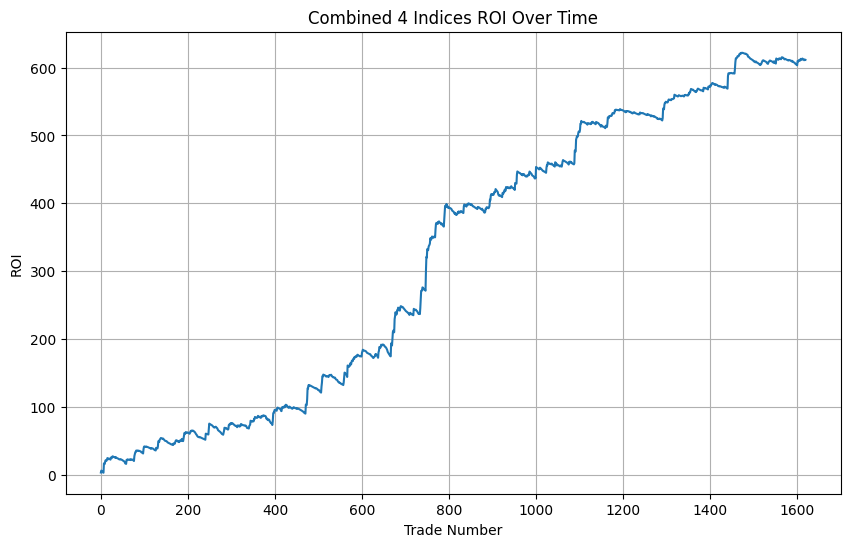

In [9]:
import matplotlib.pyplot as plt

# tradebook = both_indices_combined_tb
tradebook = pd.read_csv('Combined TB 4 indices.csv')

tradebook["Cumulative Returns"] = tradebook["Final ROI%"].cumsum()
plt.figure(figsize=(10, 6))
plt.plot(tradebook["Cumulative Returns"], linestyle="-")
plt.title("Combined 4 Indices ROI Over Time")
plt.xlabel("Trade Number")
plt.ylabel("ROI")
plt.grid(True)
plt.show()

In [3075]:
tradebook

Signal Generated At Trade Type           Entry Time  Entry Price  \
0     2017-01-09 10:15:00       LONG  2017-01-09 11:15:00    8246.5500   
1     2017-01-11 10:15:00       LONG  2017-01-11 11:15:00   18670.8500   
2     2017-01-19 10:15:00       LONG  2017-01-19 11:15:00   19108.4000   
3     2017-01-20 10:15:00       LONG  2017-01-20 11:15:00   19010.5000   
4     2017-01-24 11:15:00       LONG  2017-01-24 12:15:00   18977.7500   
5     2017-01-24 12:15:00       LONG  2017-01-24 13:15:00    8445.3000   
6     2017-01-24 13:15:00       LONG  2017-01-24 14:15:00   19013.1500   
7     2017-01-24 14:15:00       LONG  2017-01-24 15:15:00    8476.1000   
8     2017-01-31 11:15:00       LONG  2017-01-31 12:15:00   19492.3000   
9     2017-01-31 15:15:00       LONG  2017-02-01 09:15:00   19543.4500   
10    2017-02-01 12:15:00       LONG  2017-02-01 13:15:00    8658.8000   
11    2017-02-01 12:15:00       LONG  2017-02-01 13:15:00   19941.7000   
12    2017-02-08 12:15:00       LONG  2017-02-08 13:15:00   20297.3000   
13    2017-02-08 14:15:00       LONG  2017-02-08 15:15:00   20300.1000   
14    2017-02-09 11:15:00       LONG  2017-02-09 12:15:00    8755.5500   
15    2017-02-09 11:15:00       LONG  2017-02-09 12:15:00   20108.3000   
16    2017-02-13 12:15:00       LONG  2017-02-13 13:15:00   20194.2000   
17    2017-02-13 13:15:00       LONG  2017-02-13 14:15:00    8803.8000   
18    2017-02-14 12:15:00       LONG  2017-02-14 13:15:00   20228.7500   
19    2017-02-17 10:15:00       LONG  2017-02-17 11:15:00    8836.8000   
20    2017-02-17 10:15:00       LONG  2017-02-17 11:15:00   20707.2000   
21    2017-02-20 09:15:00       LONG  2017-02-20 10:15:00   20560.8000   
22    2017-02-20 10:15:00       LONG  2017-02-20 11:15:00    8840.7000   
23    2017-02-27 10:15:00       LONG  2017-02-27 11:15:00   20730.3500   
24    2017-02-27 15:15:00       LONG  2017-02-28 09:15:00   20632.2500   
25    2017-02-28 11:15:00       LONG  2017-02-28 12:15:00    8894.5000   
26    2017-02-28 13:15:00       LONG  2017-02-28 14:15:00   20614.4000   
27    2017-03-01 11:15:00       LONG  2017-03-01 12:15:00    8936.7500   
28    2017-03-01 13:15:00       LONG  2017-03-01 14:15:00    8942.4500   
29    2017-03-06 09:15:00       LONG  2017-03-06 10:15:00    8960.2500   
30    2017-03-08 14:15:00       LONG  2017-03-08 15:15:00   20687.1500   
31    2017-03-09 10:15:00       LONG  2017-03-09 11:15:00   20705.3500   
32    2017-03-09 12:15:00       LONG  2017-03-09 13:15:00    8915.2000   
33    2017-03-09 13:15:00       LONG  2017-03-09 14:15:00   20697.8000   
34    2017-03-10 11:15:00       LONG  2017-03-10 12:15:00    8941.8000   
35    2017-03-14 10:15:00       LONG  2017-03-14 11:15:00   21180.8500   
36    2017-03-14 12:15:00       LONG  2017-03-14 13:15:00    9082.9000   
37    2017-03-14 15:15:00       LONG  2017-03-15 09:15:00    9091.9000   
38    2017-03-14 15:15:00       LONG  2017-03-15 09:15:00   21116.2000   
39    2017-03-17 11:15:00       LONG  2017-03-17 12:15:00   21179.3000   
40    2017-03-20 10:15:00       LONG  2017-03-20 11:15:00   21132.6000   
41    2017-03-21 12:15:00       LONG  2017-03-21 13:15:00    9105.9500   
42    2017-03-21 12:15:00       LONG  2017-03-21 13:15:00   21028.7000   
43    2017-03-21 14:15:00       LONG  2017-03-21 15:15:00   21027.6500   
44    2017-03-21 14:15:00       LONG  2017-03-21 15:15:00    9125.6500   
45    2017-03-22 11:15:00       LONG  2017-03-22 12:15:00   20863.7500   
46    2017-03-28 09:15:00       LONG  2017-03-28 10:15:00    9096.9000   
47    2017-03-28 10:15:00       LONG  2017-03-28 11:15:00   21228.6500   
48    2017-03-29 10:15:00       LONG  2017-03-29 11:15:00    9126.1000   
49    2017-03-29 15:15:00       LONG  2017-03-30 09:15:00    9153.1500   
50    2017-03-30 12:15:00       LONG  2017-03-30 13:15:00    9157.8500   
51    2017-03-30 14:15:00       LONG  2017-03-30 15:15:00    9181.6000   
52    2017-04-03 10:15:00       LONG  2017-04-03 11:15:00   21493.3500   
53    2017

In [3078]:
tradebook.to_csv("Combined TB MIDCP LS56 BNF L4 NF L5 MTrend v2.csv")

In [244]:
df1 = pd.read_csv("BNF Since 2012 JJMS MTrend.csv")
df2 = pd.read_csv("NIFTY Since 2012 JJMS MTrend.csv")

comb = pd.concat([df1, df2], ignore_index=True)

comb.head()

Unnamed: 0  Signal Generated At Trade Type           Entry Time  \
0           0  2012-01-11 10:15:00       LONG  2012-01-11 11:15:00   
1           1  2012-01-11 15:15:00       LONG  2012-01-12 09:15:00   
2           2  2012-01-16 11:15:00       LONG  2012-01-16 12:15:00   
3           3  2012-01-18 12:15:00       LONG  2012-01-18 13:15:00   
4           4  2012-01-19 10:15:00       LONG  2012-01-19 11:15:00   

   Entry Price  Initial SL  Final SL            Exit Time  Exit Price  \
0    8800.8000   8759.2000 8759.2000  2012-01-11 14:15:00   8759.2000   
1    8858.9500   8821.4500 8925.9750  2012-01-16 09:15:00   8880.5500   
2    8870.5500   8813.8500 8980.5778  2012-01-18 11:15:00   8951.7500   
3    8972.3500   8924.2500 8924.2500  2012-01-18 13:15:00   8924.2500   
4    9181.6000   9145.8000 9780.1778  2012-01-27 11:15:00   9756.8500   

   Points Captured  After Costs         PnL         Remarks   Qty Leverage  \
0         -41.6000     -43.3560 -49425.8400  Initial SL hit  1140       5x   
1          21.6000      19.8260  22304.3062         TSL Hit  1125       5x   
2          81.2000      79.4178  89344.9913         TSL Hit  1125       5x   
3         -48.1000     -49.8897 -55377.5226  Initial SL Hit  1110       5x   
4         575.2500     573.3562 627824.9897         TSL Hit  1095       5x   

     ROI%  Trade Year  Trade Month     DD%  
0 -1.9770        2012            1  0.0000  
1  0.8922        2012            1  0.0000  
2  3.5738        2012            1  0.0000  
3 -2.2151        2012            1 -2.2151  
4 25.1130        2012            1  0.0000

In [245]:
comb["Entry Time"] = pd.to_datetime(comb["Entry Time"])
comb = comb.sort_values(by="Entry Time")
comb.head()

Unnamed: 0  Signal Generated At Trade Type          Entry Time  \
1084           0  2012-01-06 13:15:00       LONG 2012-01-06 14:15:00   
1085           1  2012-01-09 10:15:00       LONG 2012-01-09 11:15:00   
0              0  2012-01-11 10:15:00       LONG 2012-01-11 11:15:00   
1              1  2012-01-11 15:15:00       LONG 2012-01-12 09:15:00   
2              2  2012-01-16 11:15:00       LONG 2012-01-16 12:15:00   

      Entry Price  Initial SL  Final SL            Exit Time  Exit Price  \
1084    4722.6500   4696.5000 4696.5000  2012-01-09 09:15:00   4696.5000   
1085    4715.5000   4701.7000 5112.3387  2012-01-30 14:15:00   5083.6500   
0       8800.8000   8759.2000 8759.2000  2012-01-11 14:15:00   8759.2000   
1       8858.9500   8821.4500 8925.9750  2012-01-16 09:15:00   8880.5500   
2       8870.5500   8813.8500 8980.5778  2012-01-18 11:15:00   8951.7500   

      Points Captured  After Costs         PnL         Remarks   Qty Leverage  \
1084         -26.1500     -27.0919 -57299.4002  Initial SL Hit  2115       5x   
1085         368.1500     367.1701 776564.7298         TSL Hit  2115       5x   
0            -41.6000     -43.3560 -49425.8400  Initial SL hit  1140       5x   
1             21.6000      19.8260  22304.3062         TSL Hit  1125       5x   
2             81.2000      79.4178  89344.9913         TSL Hit  1125       5x   

        ROI%  Trade Year  Trade Month    DD%  
1084 -2.2920        2012            1 0.0000  
1085 31.0626        2012            1 0.0000  
0    -1.9770        2012            1 0.0000  
1     0.8922        2012            1 0.0000  
2     3.5738        2012            1 0.0000

In [246]:
comb.loc[comb["Trade Year"] >= 2012, "Qty"] /= 2

/tmp/ipykernel_462373/1836691918.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1057.5 1057.5  570.  ...  105.    97.5   97.5]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  comb.loc[comb["Trade Year"] >= 2012, "Qty"] /= 2


In [247]:
comb["PnL"] = comb["After Costs"] * comb["Qty"]
comb["ROI%"] = comb["PnL"] * 100 / 2500000

In [249]:
comb["Cumulative ROI%"] = comb["ROI%"].cumsum()
comb["Running Max ROI%"] = comb["Cumulative ROI%"].cummax()
comb["Drawdown"] = comb["Cumulative ROI%"] - comb["Running Max ROI%"]
comb.head()

Unnamed: 0  Signal Generated At Trade Type          Entry Time  \
1084           0  2012-01-06 13:15:00       LONG 2012-01-06 14:15:00   
1085           1  2012-01-09 10:15:00       LONG 2012-01-09 11:15:00   
0              0  2012-01-11 10:15:00       LONG 2012-01-11 11:15:00   
1              1  2012-01-11 15:15:00       LONG 2012-01-12 09:15:00   
2              2  2012-01-16 11:15:00       LONG 2012-01-16 12:15:00   

      Entry Price  Initial SL  Final SL            Exit Time  Exit Price  \
1084    4722.6500   4696.5000 4696.5000  2012-01-09 09:15:00   4696.5000   
1085    4715.5000   4701.7000 5112.3387  2012-01-30 14:15:00   5083.6500   
0       8800.8000   8759.2000 8759.2000  2012-01-11 14:15:00   8759.2000   
1       8858.9500   8821.4500 8925.9750  2012-01-16 09:15:00   8880.5500   
2       8870.5500   8813.8500 8980.5778  2012-01-18 11:15:00   8951.7500   

      Points Captured  After Costs         PnL         Remarks       Qty  \
1084         -26.1500     -27.0919 -28649.7001  Initial SL Hit 1057.5000   
1085         368.1500     367.1701 388282.3649         TSL Hit 1057.5000   
0            -41.6000     -43.3560 -24712.9200  Initial SL hit  570.0000   
1             21.6000      19.8260  11152.1531         TSL Hit  562.5000   
2             81.2000      79.4178  44672.4956         TSL Hit  562.5000   

     Leverage    ROI%  Trade Year  Trade Month    DD%  Cumulative ROI%  \
1084       5x -1.1460        2012            1 0.0000          -1.1460   
1085       5x 15.5313        2012            1 0.0000          14.3853   
0          5x -0.9885        2012            1 0.0000          13.3968   
1          5x  0.4461        2012            1 0.0000          13.8429   
2          5x  1.7869        2012            1 0.0000          15.6298   

      Running Max ROI%  Drawdown  
1084           -1.1460    0.0000  
1085           14.3853    0.0000  
0              14.3853   -0.9885  
1              14.3853   -0.5424  
2              15.6298    0.0000

In [252]:
stats_df8 = pd.DataFrame(
    index=range(2012, 2025),
    columns=[
        "Total ROI",
        "Total Trades",
        "Win Rate",
        "Avg Profit% per Trade",
        "Avg Loss% per Trade",
        "Max Drawdown",
        "ROI/DD Ratio",
    ],
)
combined_df_sorted = comb
combined_df_sorted["Total ROI%"] = combined_df_sorted["ROI%"]
# Iterate over each year
for year in range(2012, 2025):
    # Filter trades for the current year
    year_trades = combined_df_sorted[(combined_df_sorted["Trade Year"] == year)]

    # Calculate total ROI
    total_roi = year_trades["Total ROI%"].sum()

    # Calculate total number of trades
    total_trades = len(year_trades)

    # Calculate win rate
    win_rate = (year_trades["Total ROI%"] > 0).mean() * 100

    # Calculate average profit per trade
    avg_profit = year_trades[year_trades["Total ROI%"] > 0]["Total ROI%"].mean()

    # Calculate average loss per trade
    avg_loss = year_trades[year_trades["Total ROI%"] < 0]["Total ROI%"].mean()

    # Calculate maximum drawdown
    max_drawdown = (
        year_trades["Total ROI%"].cumsum() - year_trades["Total ROI%"].cumsum().cummax()
    ).min()

    # Calculate ROI/DD ratio
    roi_dd_ratio = total_roi / abs(max_drawdown)

    # Store the statistics in the DataFrame
    stats_df8.loc[year] = [
        total_roi,
        total_trades,
        win_rate,
        avg_profit,
        avg_loss,
        max_drawdown,
        roi_dd_ratio,
    ]

# Calculate overall statistics
overall_total_roi = stats_df8["Total ROI"].sum()
overall_total_trades = stats_df8["Total Trades"].sum()
overall_win_rate = (combined_df_sorted["Total ROI%"] > 0).mean() * 100
overall_avg_profit = combined_df_sorted[combined_df_sorted["Total ROI%"] > 0][
    "Total ROI%"
].mean()
overall_avg_loss = combined_df_sorted[combined_df_sorted["Total ROI%"] < 0][
    "Total ROI%"
].mean()
overall_max_drawdown = (
    combined_df_sorted["Total ROI%"].cumsum()
    - combined_df_sorted["Total ROI%"].cumsum().cummax()
).min()
overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)

# Store the overall statistics in the DataFrame
stats_df8.loc["Overall"] = [
    overall_total_roi,
    overall_total_trades,
    overall_win_rate,
    overall_avg_profit,
    overall_avg_loss,
    overall_max_drawdown,
    overall_roi_dd_ratio,
]
stats_df8

Total ROI Total Trades Win Rate Avg Profit% per Trade  \
2012      76.4972          158  27.8481                3.9700   
2013      37.2766          138  23.9130                4.2144   
2014     127.4984          149  29.5302                4.6171   
2015      23.1528          131  25.9542                2.9153   
2016      22.2047          152  21.7105                3.5913   
2017      25.8692          189  28.5714                2.0034   
2018      43.1049          137  31.3869                2.4910   
2019      68.7364          132  28.0303                3.6179   
2020     168.5118          120  35.8333                5.8762   
2021      86.9386          142  28.8732                4.3289   
2022      49.5638          139  25.8993                3.9050   
2023      58.1040          143  32.8671                2.3494   
2024      -3.5786           74  21.6216                2.2433   
Overall  783.8797    1804.0000  27.9933                3.5659   

        Avg Loss% per Trade Max Drawdown ROI/DD Ratio  
2012                -0.8613     -20.4448       3.7416  
2013                -0.9695     -36.4665       1.0222  
2014                -0.7205     -13.8698       9.1925  
2015                -0.7832     -18.7007       1.2381  
2016                -0.8093     -24.2499       0.9157  
2017                -0.6098     -14.2085       1.8207  
2018                -0.6809     -16.7316       2.5763  
2019                -0.6856     -11.5623       5.9449  
2020                -1.0930     -14.5069      11.6160  
2021                -0.8965     -17.4085       4.9940  
2022                -0.8837     -21.9185       2.2613  
2023                -0.5450     -12.0072       4.8391  
2024                -0.6806     -11.3305      -0.3158  
Overall             -0.7828     -36.4665      21.4959